In [ ]:
We are going to 

In [2]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import pandas as pd

import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist

from numpyro import sample
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

In [164]:
from jax import vmap

In [104]:
import arviz as az

In [28]:
from numpyro.handlers import seed, substitute, trace

In [5]:
key = random.PRNGKey(0)

# Intro

Let's set up a simple distributional model, and attempt to do online updates as more data arrives. 

We will start with a simple 1D Gaussian

When we have MCMC sample from the posterior, it is not generally possible to convert it to a prior, because we do not have the probability density. So a sure way is to just re-run the MCMC. However, we can use Sampling Importance Resampling to approximately incorporate the new data online. 

# SIR (Sampling Importance Resampling)

Main idea: 
1. We have a large iid sample from prior
2. We have an observation
3. We will subsample the sample from prior, according to the observation to get a sample from posterior

# Example 0: Main idea of SIR

Let's say, we want to have a sample from normal distribution within the interval [-1,1].

One way to do this is to sample normal, then reject anything that's not in [-1,1]. 

A better way is SIR, where we re-weigh samples instead of rejecting them

In [136]:
N = 10_0000
key, key1, key2 = random.split(key, 3)
x = random.uniform(key1, (N,), minval = -1., maxval= 1.)
y = random.normal(key1, (N,))

## Rejection

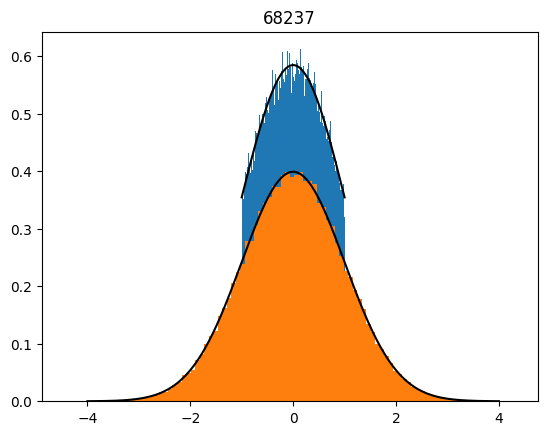

In [137]:
samp = y[(y>-1)&(y<1)]
plt.hist(samp, bins = 100, density= True);
plt.hist(y, bins = 100, density= True);

t = np.linspace(-1, 1., 300)
c = dist.Normal().cdf(1.)-dist.Normal().cdf(-1.)
plt.plot(t, np.exp(dist.Normal().log_prob(t))/c, color = 'k')

t = np.linspace(-4, 4, 300)
plt.plot(t, np.exp(dist.Normal().log_prob(t)), color = 'k')

plt.title(samp.shape[0]);

## SIR

In [138]:
w = np.exp(dist.Normal().log_prob(x))

In [139]:
x1 = random.choice(key, x, (68419,), p = w/sum(w))

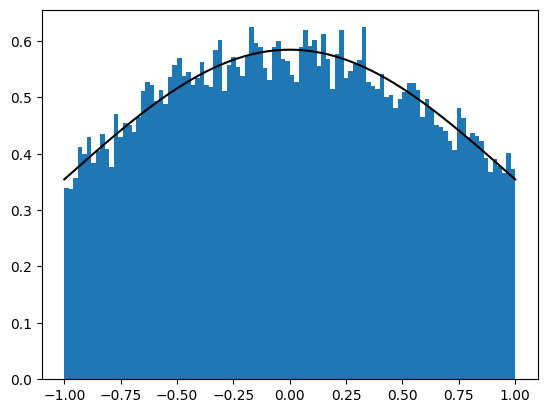

In [140]:
plt.hist(x1, bins = 100, density = True);
t = np.linspace(-1, 1., 300)
c = dist.Normal().cdf(1.)-dist.Normal().cdf(-1.)
plt.plot(t, np.exp(dist.Normal().log_prob(t))/c, color = 'k')


# Example 1: 1D Gaussian

Let's fit the mean and std of a Gaussian 

1. Initial fit using N1 observations via MCMC. 
2. Add online N2 observations (without MCMC)
3. Compare against fit using N1+N2 observations with MCMC

**The caveat is that after re-weighting we might end up with a sparse sample, because the new sample is being selected from the MCMC sample**


In [292]:
def get_data_1D(key, mu = .5, scale = .5, N = 10):
    key, key1 = random.split(key)
    return key, mu+random.normal(key1, (N,))*scale

In [336]:
N1 = 20 # initial data for which we will have MCMC
N2 = 10 # additional online data, for which we will re-use MCMC
N_mcmc = 5000 # number of MCMC samples

key, x1 = get_data_1D(key, N = N1)
key, x2 = get_data_1D(key, N = N2)

In [337]:
def model_1d(data = None):
    
    mu = sample('mu', dist.Normal(loc = 0., scale = 3.))
    std = sample('std', dist.LogNormal(0.0, 10.0))
    
    sample('obs', dist.Normal(mu, std), obs = data)

## Initial fit

Fit using x1 as training data

In [338]:


kernel = NUTS(model_1d)
mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=N_mcmc,
        num_chains=1
    )

In [339]:
mcmc.run(key, x1)
mcmc.print_summary()

sample: 100%|█| 6000/6000 [00:06<00:00, 857.87it/s, 1 steps of size 8.82e-01. ac


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.37      0.13      0.36      0.15      0.57   3190.00      1.00
       std      0.56      0.10      0.55      0.41      0.71   2975.97      1.00

Number of divergences: 0


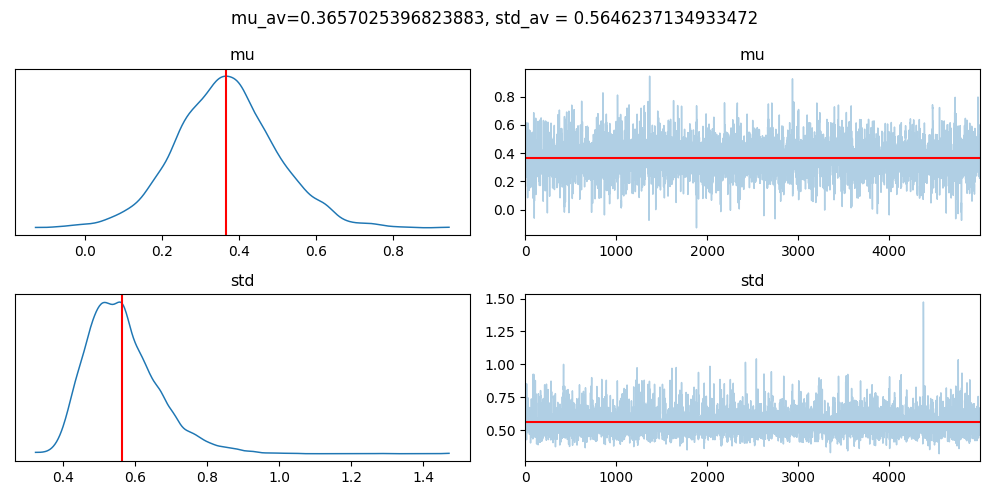

In [340]:
data = az.from_numpyro(mcmc)

mu_av1 = mcmc.get_samples()['mu'].mean()
std_av1 = mcmc.get_samples()['std'].mean()

fig, ax = plt.subplots(2,2, figsize = (10, 5))
ax = az.plot_trace(data, axes = ax);


ax[0,0].axvline(mu_av1, color = 'r')
ax[0,1].axhline(mu_av1, color = 'r')

ax[1,0].axvline(std_av1, color = 'r')
ax[1,1].axhline(std_av1, color = 'r');

fig.suptitle(f'mu_av={mu_av1}, std_av = {std_av1}')

fig.tight_layout();

## Refine initial fit in online-regime

Evaluate log-likelihood of each new data point using existing MCMC. 

The resampling weights are normalised values of log-likelihood at new points

If we have N2 new data points, since they are independent, we will add up the log-likelihoods to get the weights. 

`ind` is our resampling indices. Drawing MCMC samples of `ind` should give us the approximate new posterior, trained with old and newdata. 

In [341]:
mu_1 = mcmc.get_samples()['mu']
std_1 = mcmc.get_samples()['std']

# log probability dimensions: (size of data, size of MCMC)
log_p = vmap(lambda t: dist.Normal(loc = mu_1, scale = std_1).log_prob(t))

LP = log_p(x2)
LP.shape

(10, 5000)

In [342]:
p = np.exp(LP.sum(axis = 0))

In [343]:
# resampling indices
ind = random.choice(key, np.arange(N_mcmc), (N_mcmc,), p = p/p.sum())

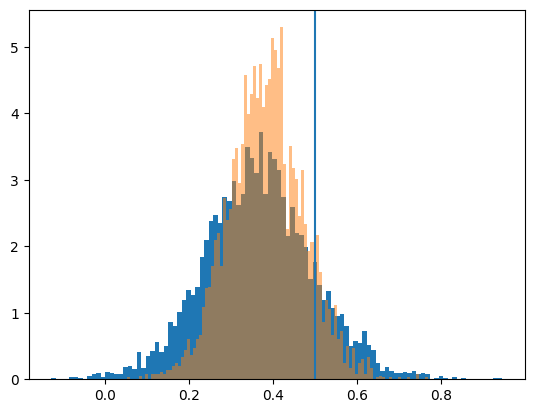

In [346]:
plt.hist(mu_1, bins = 100, density = True);
plt.hist(mu_1[ind], bins = 100, alpha = .5, density = True);
plt.axvline(.5)

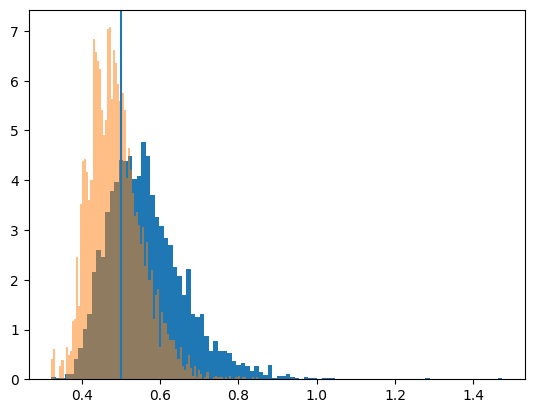

In [347]:
plt.hist(std_1, bins = 100, density = True);
plt.hist(std_1[ind], bins = 100, alpha = .5, density = True);
plt.axvline(.5)

In [348]:
mu_1.mean(), mu_1[ind].mean(),

(DeviceArray(0.36570254, dtype=float32), DeviceArray(0.3838667, dtype=float32))

In [349]:
std_1.mean(), std_1[ind].mean(), 

(DeviceArray(0.5646237, dtype=float32), DeviceArray(0.487318, dtype=float32))

# Check
What will the parameters look like if we MCMC sample directly with x3

In [350]:
mcmc.run(key, np.concatenate((x1,x2)))
mcmc.print_summary()

sample: 100%|█| 6000/6000 [00:06<00:00, 892.30it/s, 1 steps of size 8.54e-01. ac



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.38      0.09      0.38      0.23      0.53   3221.82      1.00
       std      0.49      0.07      0.48      0.37      0.59   3663.68      1.00

Number of divergences: 0


In [351]:
mcmc.get_samples()['mu'].mean(), mcmc.get_samples()['std'].mean(), 

(DeviceArray(0.38288602, dtype=float32),
 DeviceArray(0.48892128, dtype=float32))